<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/train_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning recognizer with keras-ocr

This is an interactive example of the code documented in https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html

In [1]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install imgaug==0.2.9
!pip install -U opencv-python # We need the most recent version of OpenCV.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-8qhkszss/keras-ocr_8d9dd6475b7a457c83119fe5662b1bd9
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-8qhkszss/keras-ocr_8d9dd6475b7a457c83119fe5662b1bd9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.5 MB 34.4 MB/s 
     |████████████████████████████████| 930 kB 57.4 MB/s 
     |████████████████████████████████| 604 kB 56.2 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.9.0.post2+40bb9bd-py3-none-any.whl size=42441 sha256=395ed38f34cb967c37e2cf7ce5f322a5231d7070ae68addf74cc2ca4a5851340
  Stored in directory: /tmp/pip-ephem-wheel-cache-nmzuc7he/wheels/20/d0/06/ed290995144ec8dde71d3a91

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/Colab_Notebooks/VU/utils.py /content

Mounted at /content/drive


In [4]:
from utils import *

In [2]:
import random
import string
import math
import itertools
import os
import cv2 as cv

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.config.list_physical_devices('GPU')

## Dataset loading (training data)

**CTW1500 dataset**

Get images. Update location of images **manually**.

In [5]:
# path to image directory, get full path to all files
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/train_images'
(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames]
n_imgs = len(list_img_paths)

# load images
train_images = [(cv.imread(file)) for file in list_img_paths]

# path to label directory, get full path to all files
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/ctw1500_train_labels'
(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files]



Get ground truths from all xml files

In [6]:
ground_truth = []

for i, file in enumerate(list_xml_paths):
     ground_truth.append(read_gt_ctw_train(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

In [ ]:
! rm -r /content/train_data/


From CTW 1000 training images we obain 7405 cropped images = texts.

In [7]:
cropped_gt = image_text_crop(train_images, filenames, ground_truth,  result_folder='./train_data')
train_dir = '/content/train_data/'
(_, _, train_files) = next(os.walk(train_dir))
train_files = [os.path.join(train_dir, file) for file in sorted(train_files)]

1000it [00:12, 77.64it/s]


In [34]:
import string
alphabet = string.ascii_letters + string.digits + '* /.:,+-¥$%&=!?'

In [30]:
print(string.ascii_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


In [9]:
train_lbls = [
    (filepath, None, ' '.join(''.join(
        char for char in word.split('\t',1)[1] if (char in alphabet)).split()) ) 
    for filepath, word in list(zip(train_files, cropped_gt))
    ]

We next build our recognizer, using the default options to get a pretrained model.

In [35]:
recognizer = keras_ocr.recognition.Recognizer(alphabet=alphabet)
recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [12]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_lbls, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

In [13]:
len(validation_labels)

1481

As a sanity check, we show one of the samples.

text: PENNY FOR PENNY.


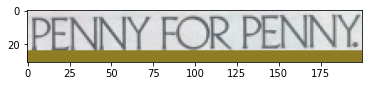

In [14]:
image, text = next(validation_image_gen)
print('text:', text)
_ = plt.imshow(image)

### Training

In [38]:
recognizer.model.load_weights('recognizer_ctw3.h5')

In [42]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_ctw4_cont.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_ctw_cont.csv')
]

recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=100,
)

Epoch 1/100
740/740 [==============================] - 88s 108ms/step - loss: 14.2685 - val_loss: 20.5361
Epoch 2/100
740/740 [==============================] - 77s 104ms/step - loss: 13.7432 - val_loss: 19.9845
Epoch 3/100
740/740 [==============================] - 76s 103ms/step - loss: 15.0463 - val_loss: 24.1202
Epoch 4/100
740/740 [==============================] - 78s 105ms/step - loss: 15.1730 - val_loss: 19.6230
Epoch 5/100
740/740 [==============================] - 77s 103ms/step - loss: 12.5834 - val_loss: 20.2977
Epoch 6/100
740/740 [==============================] - 76s 103ms/step - loss: 12.1846 - val_loss: 20.0616
Epoch 7/100
740/740 [==============================] - 76s 103ms/step - loss: 12.0041 - val_loss: 20.2306
Epoch 8/100
740/740 [==============================] - 76s 103ms/step - loss: 11.7752 - val_loss: 21.6563
Epoch 9/100
740/740 [==============================] - 78s 106ms/step - loss: 11.1631 - val_loss: 20.0144
Epoch 10/100
740/740 [========================

Finally, run inference on a test sample.

Predicted: majesilig, Actual: MAJESTIC


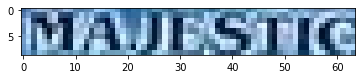

In [29]:
image_filepath, _, actual = train_labels[2]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [43]:
recognizer.model.load_weights('recognizer_ctw4_cont.h5')

Predicted: NO OUVOESIU ROO DE RAMLBAN COMUNON, Actual: NO OLVIDES TU FOTO DE PRIMERA COMUNION


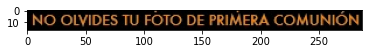

In [47]:
image_filepath, _, actual = train_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))